## Extracting data with the [NetCDF subset service](http://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html) (`siphon.ncss`)

### We got the url by navigating the THEDDS catalog because we could not find it navigating the metadata with siphon. See [siphon-explore-catalog.ipynb](http://localhost:8888/notebooks/siphon-explore-catalog.ipynb#But-it-seems-that-the-catalog-must-offer-the-NetcdfSubset-in-the-access_urls.-Let's-see-if-we-have-that-in-this-catalog.).

In [1]:
from siphon.ncss import NCSS

subset = NCSS('http://thredds.cencoos.org/thredds/ncss/'
              'G1_SST_US_WEST_COAST.nc')

### Let's inspect the `subset` object.

In [2]:
[value for value in dir(subset) if not value.startswith('__')]

['_base',
 '_get_metadata',
 '_session',
 'get',
 'get_data',
 'get_data_raw',
 'get_path',
 'get_query',
 'metadata',
 'query',
 'unit_handler',
 'url_path',
 'validate_query',
 'variables']

### `subset.metadata` seems to be what we want.

In [3]:
[value for value in dir(subset.metadata) if not value.startswith('__')]

['_get_handler',
 '_parse_AcceptList',
 '_parse_LatLonBox',
 '_parse_TimeSpan',
 '_parse_axis',
 '_parse_coordTransform',
 '_parse_element',
 '_parse_featureDataset',
 '_parse_gridset',
 '_parse_variable',
 '_types',
 '_types_methods',
 'accept_list',
 'axes',
 'featureDataset',
 'gridsets',
 'lat_lon_box',
 'time_span',
 'variables']

### Before making our own request we need to know the data time and space domains.

In [4]:
subset.metadata.time_span

{'begin': '2010-12-01T00:00:00Z', 'end': '2013-12-31T00:00:00Z'}

In [5]:
subset.metadata.lat_lon_box

{'east': -105.0049, 'north': 54.9949, 'south': 23.995, 'west': -140.005}

### And what variables are available.

In [6]:
subset.variables

{'analysed_sst'}

In [7]:
subset.metadata.variables

{'analysed_sst': {'attributes': {'coordinates': 'time lat lon lat lon',
   'coverage_content_type': 'modelResult',
   'long_name': 'analysed sea surface temperature',
   'missing_value': '-273.15',
   'standard_name': 'sea_surface_temperature',
   'type': 'foundation',
   'units': 'degree_Celsius'},
  'desc': 'analysed sea surface temperature',
  'shape': 'time lat lon',
  'type': 'float'}}

### Now we can create a query.

In [8]:
query = subset.query()

### Add space and time constraints.

In [9]:
query.lonlat_box(east=-120, north=50, south=35, west=-135)

east=-120&south=35&north=50&west=-135

In [10]:
from datetime import datetime

query.time(datetime(2013, 12, 31))

time=2013-12-31T00%3A00%3A00&east=-120&south=35&north=50&west=-135

### And the variable constraint.

In [11]:
variable = 'analysed_sst'

query.variables(variable)

var=analysed_sst&time=2013-12-31T00%3A00%3A00&east=-120&south=35&north=50&west=-135

### `query` prints the constraints we have so far but you can also inspect them.

In [12]:
query.spatial_query, query.time_query

(OrderedDict([('east', -120), ('south', 35), ('north', 50), ('west', -135)]),
 OrderedDict([('time', '2013-12-31T00:00:00')]))

### To request the data we need to pass the `query` object back to the `subset` object.

In [13]:
%%time

data = subset.get_data(query)

CPU times: user 182 ms, sys: 112 ms, total: 294 ms
Wall time: 24.5 s


In [14]:
type(data)

netCDF4._netCDF4.Dataset

### `siphon.ncss` returns by default a `netCDF4-python` object. Nice!

### But note that it took more time to get the data than we would expect if doing the same using `OPeNDAP`. The reason for that is because siphon is downloading all the data and saving it in the disk.

In [15]:
data.filepath()

'/tmp/tmpnd_10is9'

### Does the data real limits make sense with our constraints?

In [16]:
import numpy.ma as ma

lon = data['lon'][:]
lat = data['lat'][:]

temp = data[variable][:]
temp = ma.masked_invalid(temp.squeeze())

time = data['time']
time = ''.join(time[:][0].astype(str).tolist())

In [17]:
lon[0], lon[-1], lat[0], lat[-1], time

(-134.995, -119.995, 34.994999, 50.005001, '2013-12-31T00:00:00Z')

### They are all within the queried constraints as expected.

### Let's end the example with a plot!

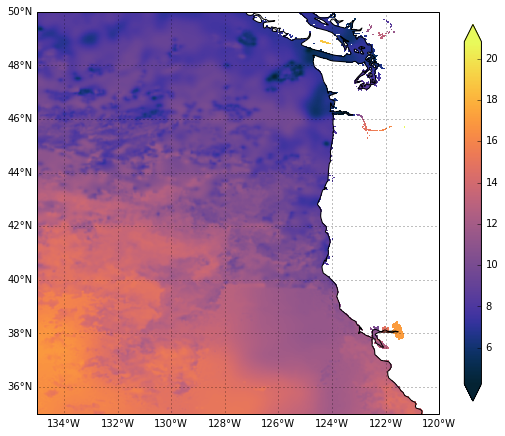

In [18]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cmocean import cm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, ax = plt.subplots(figsize=(9, 9),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.coastlines(resolution='50m')
cs = ax.pcolormesh(lon, lat, temp, cmap=cm.thermal)
cbar = fig.colorbar(cs, extend='both', shrink=0.75)

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER